In [33]:
import os, os.path
import numpy as np
import cv2
import re 

In [34]:
def getData(picPath, n = 17, res = (320, 320)):
    path, dirs, files = next(os.walk(picPath))
    dirs = sorted(dirs)
    print (dirs)
    images = []
    temp = []
    for i in range(len(dirs)):
        path1, dirs1, files1 = next(os.walk(str(picPath)+'/'+str(dirs[i])))
        print(path1)
        print(i)
        files1 = sorted(files1, key=lambda d: re.findall('[0-9]+', d))
        print(files1)
        t=[]
        for j in range(n):
            img = cv2.imread(path1+'/'+files1[j], 0)
            img = cv2.resize(img, res)
            t.append(img)
        temp.append(t)
        images.append(t)
    return images

In [12]:
images = getData("pic", res=(128, 128))

['0000-0016', '1817-1834', '1835-1851', '1852-1908', '1909-1925', '1926-1942', '1943-1959', '2000-2016', '2017-2034', '2035-2051', '2052-2108', '2109-2125', '2126-2142', '2143-2159', '2200-2216', '2217-2234', '2235-2251', '2252-2308', '2309-2325', '2326-2342', '2343-2359', '2401-2417', '2418-2432']
pic/0000-0016
0
['340.png', '341.png', '342.png', '343.png', '344.png', '345.png', '346.png', '347.png', '348.png', '349.png', '350.png', '351.png', '352.png', '353.png', '354.png', '355.png', '356.png']
pic/1817-1834
1
['0.png', '1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
pic/1835-1851
2
['17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png']
pic/1852-1908
3
['34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.p

In [13]:
def makeNpy(images, name = 'data.npy', path = ''):
    np.save(path + name, images) # save

In [14]:
makeNpy(images)

In [15]:
dataset = np.load("data.npy")

In [16]:
print(dataset.shape)

(23, 17, 128, 128)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [18]:
def prepData(path = 'data.npy'):
    dataset = np.load(path)
    
    # Add a channel dimension since the images are grayscale.
    dataset1 = dataset
    dataset = np.expand_dims(dataset, axis=-1)

    # Split into train and validation sets using indexing to optimize memory.
    indexes = np.arange(dataset.shape[0])
    np.random.shuffle(indexes)
    train_index = indexes[: int(0.9 * dataset.shape[0])]
    val_index = indexes[int(0.9 * dataset.shape[0]) :]
    train_dataset = dataset[train_index]
    train_dataset1 = dataset1[train_index]
    val_dataset = dataset[val_index]

    # Normalize the data to the 0-1 range.
    train_dataset = train_dataset / 255
    train_dataset1 = train_dataset1 / 255
    val_dataset = val_dataset / 255

    # We'll define a helper function to shift the frames, where
    # `x` is frames 0 to n - 1, and `y` is frames 1 to n.
    def create_shifted_frames(data):
        x = data[:, 0 : data.shape[1] - 1, :, :]
        y = data[:, 1 : data.shape[1], :, :]
        return x, y

    # Apply the processing function to the datasets.
    x_train, y_train = create_shifted_frames(train_dataset)
    x_val, y_val = create_shifted_frames(val_dataset)

    # Inspect the dataset.
    print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
    print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
    train_dataset1 = np.swapaxes(train_dataset1, 0, 1)
    
    return x_train, y_train, x_val, y_val, train_dataset, val_dataset

In [19]:
x_train, y_train, x_val, y_val, train_dataset, val_dataset = prepData()

Training Dataset Shapes: (20, 16, 128, 128, 1), (20, 16, 128, 128, 1)
Validation Dataset Shapes: (3, 16, 128, 128, 1), (3, 16, 128, 128, 1)


In [20]:
def showData(train_dataset1, data_choice = 0):

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(train_dataset1[data_choice][idx], cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
    print(f"Displaying frames for example {data_choice}.")
    plt.show()

Displaying frames for example 4.


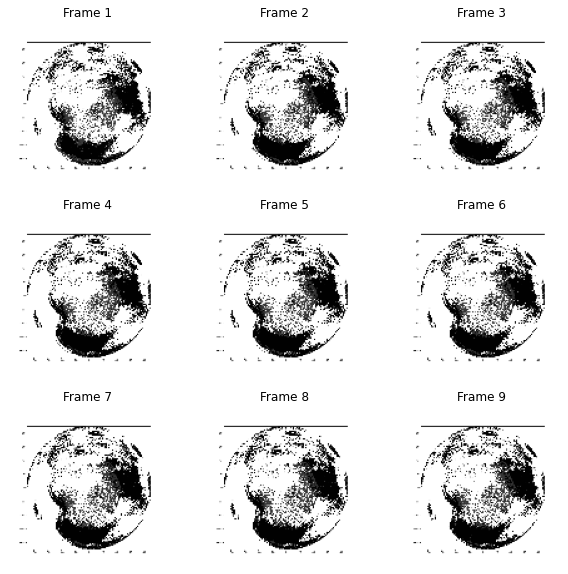

In [21]:
showData(x_train, 4)

In [13]:
def trainModel(x_train, y_train, x_val, y_val, epochs = 20, batch_size = 5):    
    inp = layers.Input(shape=(None, *x_train.shape[2:]))

    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = keras.models.Model(inp, x)
    model.compile(
        loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
    )
    # Define some callbacks to improve training.
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

    # Fit the model to the training data.
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr],
    )
    return model

In [14]:
model = trainModel(x_train, y_train, x_val, y_val)

Epoch 1/20
4/4 [==============================] - 307s 76s/step - loss: 0.5476 - val_loss: 0.6523 - lr: 0.0010
Epoch 2/20
4/4 [==============================] - 297s 75s/step - loss: 0.2568 - val_loss: 0.5731 - lr: 0.0010
Epoch 3/20
4/4 [==============================] - 297s 75s/step - loss: 0.2083 - val_loss: 0.6064 - lr: 0.0010
Epoch 4/20
4/4 [==============================] - 299s 75s/step - loss: 0.1897 - val_loss: 0.6049 - lr: 0.0010
Epoch 5/20
4/4 [==============================] - 297s 75s/step - loss: 0.1802 - val_loss: 0.5903 - lr: 0.0010
Epoch 6/20
4/4 [==============================] - 297s 75s/step - loss: 0.1733 - val_loss: 0.5681 - lr: 0.0010
Epoch 7/20
4/4 [==============================] - 298s 75s/step - loss: 0.1682 - val_loss: 0.5516 - lr: 0.0010
Epoch 8/20
4/4 [==============================] - 295s 75s/step - loss: 0.1638 - val_loss: 0.5318 - lr: 0.0010
Epoch 9/20
4/4 [==============================] - 296s 75s/step - loss: 0.1633 - val_loss: 0.5126 - lr: 0.0010
E

In [21]:
def saveModel(model, path = 'model'):
    model.save(path)

In [24]:
saveModel(model)

INFO:tensorflow:Assets written to: model\assets


In [22]:
def loadModel(path = 'model'):
    from tensorflow import keras
    model = keras.models.load_model(path)
    return model

In [23]:
model = loadModel()

In [24]:
def predict(model, val_dataset, n, video = 1):
    # Select a few random examples from the dataset.
    examples = val_dataset[np.random.choice(range(len(val_dataset)), size=video)]

    # Iterate over the examples and predict the frames.
    predicted_videos = []
    for example in examples:
        # Pick the first/last ten frames from the example.
        frames = example[:n, ...]
        original_frames = example[n:, ...]
        new_predictions = np.zeros(shape=(n, *frames[0].shape))

        # Predict a new set of 10 frames.
        for i in range(n):
            # Extract the model's prediction and post-process it.
            frames = example[: n + i + 1, ...]
            new_prediction = model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # Extend the set of prediction frames.
            new_predictions[i] = predicted_frame

        # Create and save GIFs for each of the ground truth/prediction images.
        for frame_set in [original_frames, new_predictions]:
            # Construct a GIF from the selected video frames.
            current_frames = np.squeeze(frame_set)
            current_frames = current_frames[..., np.newaxis] * np.ones(3)
            current_frames = (current_frames * 255).astype(np.uint8)
            current_frames = list(current_frames)

            # Construct a GIF from the frames.
            with io.BytesIO() as gif:
                imageio.mimsave(gif, current_frames, "GIF", fps=5)
                predicted_videos.append(gif.getvalue())

    # Display the videos.
    print(" Truth\tPrediction")
    for i in range(0, len(predicted_videos), 2):
        # Construct and display an `HBox` with the ground truth and prediction.
        box = HBox(
            [
                widgets.Image(value=predicted_videos[i]),
                widgets.Image(value=predicted_videos[i + 1]),
            ]
        )
        display(box)

In [25]:
predict(model, val_dataset, 8, 3)

 Truth	Prediction


In [26]:
predict(model, val_dataset, 8, 1)

 Truth	Prediction


In [27]:
images = getData("data", n=23, res=(128, 128))

['1']
data/1
0
['2019-09-01 01.00.00.000000.png', '2019-09-01 02.00.00.000000.png', '2019-09-01 03.00.00.000000.png', '2019-09-01 04.00.00.000000.png', '2019-09-01 05.00.00.000000.png', '2019-09-01 06.00.00.000000.png', '2019-09-01 07.00.00.000000.png', '2019-09-01 08.00.00.000000.png', '2019-09-01 09.00.00.000000.png', '2019-09-01 10.00.00.000000.png', '2019-09-01 11.00.00.000000.png', '2019-09-01 12.00.00.000000.png', '2019-09-01 13.00.00.000000.png', '2019-09-01 14.00.00.000000.png', '2019-09-01 15.00.00.000000.png', '2019-09-01 16.00.00.000000.png', '2019-09-01 17.00.00.000000.png', '2019-09-01 18.00.00.000000.png', '2019-09-01 19.00.00.000000.png', '2019-09-01 20.00.00.000000.png', '2019-09-01 21.00.00.000000.png', '2019-09-01 22.00.00.000000.png', '2019-09-01 23.00.00.000000.png']


In [28]:
makeNpy(images, name = 'val.npy')

In [29]:
val = np.load("val.npy")

In [30]:
val = np.expand_dims(val, axis=-1)

In [32]:
predict(model, val, 10, 0)

 Truth	Prediction
